In [1]:
import pandas as pd
import numpy as np
from datetime import date
import re

import train_test_split as tts
import evaluation as eva
import data_util as util
import feature_selection_missing_data as femd
import do

import decision_tree
import logistic
import svm
import knn
import boosting
import bagging

In [2]:
data = util.read_csv_data("projects_2012_2013.csv")

In [3]:
femd.summarize_missing_values(data)

{'date_posted': (0, 124976),
 'datefullyfunded': (0, 124976),
 'eligible_double_your_impact_match': (0, 124976),
 'grade_level': (3, 124976),
 'poverty_level': (0, 124976),
 'primary_focus_area': (15, 124976),
 'primary_focus_subject': (15, 124976),
 'projectid': (0, 124976),
 'resource_type': (17, 124976),
 'school_charter': (0, 124976),
 'school_city': (0, 124976),
 'school_county': (0, 124976),
 'school_district': (172, 124976),
 'school_latitude': (0, 124976),
 'school_longitude': (0, 124976),
 'school_magnet': (0, 124976),
 'school_metro': (15224, 124976),
 'school_ncesid': (9233, 124976),
 'school_state': (0, 124976),
 'schoolid': (0, 124976),
 'secondary_focus_area': (40556, 124976),
 'secondary_focus_subject': (40556, 124976),
 'students_reached': (59, 124976),
 'teacher_acctid': (0, 124976),
 'teacher_prefix': (0, 124976),
 'total_price_including_optional_support': (0, 124976)}

Due to the fact the columns which contain the missing values are categorical, using origin method to fill the missing in column mean is not appropriate. Therefore, I use the most frequent value in given columns instead to fill in the missing value, which are less restricted to the type of the data.

In [4]:
data = femd.fill_na_freq(data)

In [5]:
femd.summarize_missing_values(data)

{'date_posted': (0, 124976),
 'datefullyfunded': (0, 124976),
 'eligible_double_your_impact_match': (0, 124976),
 'grade_level': (0, 124976),
 'poverty_level': (0, 124976),
 'primary_focus_area': (0, 124976),
 'primary_focus_subject': (0, 124976),
 'projectid': (0, 124976),
 'resource_type': (0, 124976),
 'school_charter': (0, 124976),
 'school_city': (0, 124976),
 'school_county': (0, 124976),
 'school_district': (0, 124976),
 'school_latitude': (0, 124976),
 'school_longitude': (0, 124976),
 'school_magnet': (0, 124976),
 'school_metro': (0, 124976),
 'school_ncesid': (0, 124976),
 'school_state': (0, 124976),
 'schoolid': (0, 124976),
 'secondary_focus_area': (0, 124976),
 'secondary_focus_subject': (0, 124976),
 'students_reached': (0, 124976),
 'teacher_acctid': (0, 124976),
 'teacher_prefix': (0, 124976),
 'total_price_including_optional_support': (0, 124976)}

After the missing value is filled, the summary statistics that all the data I am going to use is complete right now. Then we move on to define features and classifiers. First of all, we exclude personal and geographical identification recods of the variables and focus on the features representing the characteristics of the projects. We find out that lots of the features are categorical in this case. In order to make use of these features, we thransform them to binary variables

In [6]:
features = ["school_charter", "school_magnet", "primary_focus_subject", "primary_focus_area", "secondary_focus_subject",
           "secondary_focus_area", "resource_type", "poverty_level", "grade_level", 'eligible_double_your_impact_match',
           'total_price_including_optional_support', 'students_reached']
cat_features = ["school_charter", "school_magnet", "primary_focus_subject", "primary_focus_area", "secondary_focus_subject",
           "secondary_focus_area", "resource_type", "poverty_level", "grade_level", 'eligible_double_your_impact_match']
selected_columns = ["school_charter", "school_magnet", "primary_focus_subject", "primary_focus_area", "secondary_focus_subject",
           "secondary_focus_area", "resource_type", "poverty_level", "grade_level", 'eligible_double_your_impact_match',
           'date_posted', 'datefullyfunded', 'total_price_including_optional_support', 'students_reached']

In [7]:
data = data[selected_columns]
for feature in cat_features:
    data = util.category_to_binary(data, feature)
data = data[data.columns[10:]]

In [8]:
final_features = data.columns[2:]

In [9]:
def define_date(date_string):
    full_date = re.findall("([0-9]*)/([0-9]*)/([0-9]*)", date_string)[0]
    i_year, i_month, i_day = int("20" + full_date[2]), int(full_date[0]), int(full_date[1])
    return date(i_year, i_month, i_day)

In [10]:
data["date_posted"] = data.apply(lambda x: define_date(x["date_posted"]), axis=1)
data['datefullyfunded'] = data.apply(lambda x: define_date(x['datefullyfunded']), axis=1)
data["accept_day"] = data.apply(lambda x: (x['datefullyfunded'] - x["date_posted"]).days, axis=1)
data["classifier"] = 0
data.loc[data["accept_day"] > 60, "classifier"] = 1

Considering the scale may be effective in svm and logistics models, I normalized the continuous variables in the dataset with function normalization_column in data_util.py file

In [11]:
numerical_columns = ['total_price_including_optional_support', 'students_reached']
for column in numerical_columns:
    data = util.normalization_column(data, column)

In [12]:
def time_setter(time_object):
    time = 0
    if (time_object - date(2012, 6, 30)).days > 0:
        if (time_object - date(2012, 12, 31)).days > 0:
            if (time_object - date(2013, 6, 30)).days > 0:
                time = 3
            else:
                time = 2         
        else:
            time = 1

    return time 

In [13]:
data["time"] = data.apply(lambda x: time_setter(x["date_posted"]), axis=1)
classifier = 'classifier'
time_index = "time"

In [73]:
data[data["classifier"]==1].shape[0] / data.shape[0]

0.2881353219818205

The total number of features is 92 in this case, I am applying select_K_best_features function from featue_selection_missing_data.py to select the k features which contain the most variance in the pool of features. In this analysis, the number of k will be set to 30.

In [14]:
Kfeatures = list(femd.select_K_best_features(data, final_features, classifier, k=30)[1].index)

In [15]:
data_dict = tts.rolling_window_split(data, time_index, Kfeatures, classifier)

In [20]:
threshold_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
opt = []

In [ ]:
# accuracy for models
decision_tree_accuracy = do.cross_validate_performance(data_dict, "decision_tree", opt, "accuracy", threshold_list)
random_forest_accuracy = do.cross_validate_performance(data_dict, "random_forest", opt, "accuracy", threshold_list)
svm_accuracy = do.cross_validate_performance(data_dict, "svm", opt, "accuracy", threshold_list)
logistics_accuracy = do.cross_validate_performance(data_dict, "logistics", opt, "accuracy", threshold_list)
knn_accuracy = do.cross_validate_performance(data_dict, "knn", opt, "accuracy", threshold_list)


# precision for models
decision_tree_precision = do.cross_validate_performance(data_dict, "decision_tree", opt, "precision", threshold_list)
random_forest_precision = do.cross_validate_performance(data_dict, "random_forest", opt, "precision", threshold_list)
svm_precision = do.cross_validate_performance(data_dict, "svm", opt, "precision", threshold_list)
logistics_precision = do.cross_validate_performance(data_dict, "logistics", opt, "precision", threshold_list)
knn_precision = do.cross_validate_performance(data_dict, "knn", opt, "precision", threshold_list)


# recall for models
decision_tree_recall = do.cross_validate_performance(data_dict, "decision_tree", opt, "recall", threshold_list)
random_forest_recall = do.cross_validate_performance(data_dict, "random_forest", opt, "recall", threshold_list)
svm_recall = do.cross_validate_performance(data_dict, "svm", opt, "recall", threshold_list)
logistics_recall = do.cross_validate_performance(data_dict, "logistics", opt, "recall", threshold_list)
knn_recall = do.cross_validate_performance(data_dict, "knn", opt, "recall", threshold_list)


# f1 for models
decision_tree_f1 = do.cross_validate_performance(data_dict, "decision_tree", opt, "f1", threshold_list)
random_forest_f1 = do.cross_validate_performance(data_dict, "random_forest", opt, "f1", threshold_list)
svm_f1 = do.cross_validate_performance(data_dict, "svm", opt, "f1", threshold_list)
logistics_f1 = do.cross_validate_performance(data_dict, "logistics", opt, "f1", threshold_list)
knn_f1 = do.cross_validate_performance(data_dict, "knn", opt, "f1", threshold_list)


# AUC_ROC for models
decision_tree_AUC_ROC = do.cross_validate_performance(data_dict, "decision_tree", opt, "AUC_ROC", threshold_list)
random_forest_AUC_ROC = do.cross_validate_performance(data_dict, "random_forest", opt, "AUC_ROC", threshold_list)
svm_AUC_ROC = do.cross_validate_performance(data_dict, "svm", opt, "AUC_ROC", threshold_list)
logistics_AUC_ROC = do.cross_validate_performance(data_dict, "logistics", opt, "AUC_ROC", threshold_list)
knn_AUC_ROC = do.cross_validate_performance(data_dict, "knn", opt, "AUC_ROC", threshold_list)


Notice that svm models might encounters warning that solver terminated early with max_iter=1000 even with scaled features. This may due to the fact that svm package face problems of computational complexity (with non-linear svc) when the sample size is greater than 10000. Since the performance is not influenced a lot, we might assume that the model is on the track of convergence.

The cross_validate_performance function in do.py file, prevides a general pipeline to evaluate the performance of each models with different hyper-parameter passing in. The function will automatically find the best threshold which produce the highest score of the given evaluation. The list of threshold I am testing with is the percentile [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5] in the probability distribution of the predicted probabilities. The model also take cross-validated method into account and return the individual performances and average performance for the subsets of train-test split with given combination of hyper-parameters.

First of all, we compare the evaluation method using accuracy with different machine learning models and take the combination with the highest performance, and find out that knn has the highest accuracy score. However, accuracy is not a appropriate measurement in our analysis since it does not have a clear distinguision on where the accuracy comes from.

In [35]:
decision_tree_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.601298
performance_temp_model0    0.591023
performance_temp_model1    0.613667
performance_temp_model2    0.599203
Name: 30, dtype: object

In [36]:
random_forest_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.601764
performance_temp_model0    0.590322
performance_temp_model1     0.61237
performance_temp_model2    0.602599
Name: 50, dtype: object

In [37]:
svm_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.561581
performance_temp_model0    0.523357
performance_temp_model1     0.57665
performance_temp_model2    0.584735
Name: 3, dtype: object

In [38]:
logistics_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                                 1
avg_performance            0.584306
performance_temp_model0    0.578172
performance_temp_model1    0.584804
performance_temp_model2    0.589943
Name: 2, dtype: object

In [39]:
knn_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       92
avg_performance             0.602392
performance_temp_model0     0.589835
performance_temp_model1     0.611073
performance_temp_model2     0.606267
Name: 0, dtype: object

I then move on to compare the the precision between different moodels, we find out that random forest has the highest score of precision. However, it is comparingly low in the 0.3873, the models might seem to be working badly in predicting true positive from total positive prediction. However, 0.3873 is much more higher than the proportion of 1 in the total case (0.29), which means that the prediction of the model still make some improvement from the base case.

In [40]:
decision_tree_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.384299
performance_temp_model0    0.343526
performance_temp_model1    0.425548
performance_temp_model2    0.383824
Name: 30, dtype: object

In [41]:
random_forest_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     10
max_depth                        10
avg_performance            0.387322
performance_temp_model0    0.346562
performance_temp_model1    0.428002
performance_temp_model2    0.387402
Name: 10, dtype: object

In [42]:
svm_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.347084
performance_temp_model0    0.280285
performance_temp_model1    0.391586
performance_temp_model2    0.369379
Name: 3, dtype: object

In [43]:
logistics_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                                 1
avg_performance             0.36985
performance_temp_model0    0.335221
performance_temp_model1    0.399741
performance_temp_model2    0.374587
Name: 2, dtype: object

In [44]:
knn_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       92
avg_performance             0.381559
performance_temp_model0     0.337887
performance_temp_model1     0.420413
performance_temp_model2     0.386379
Name: 0, dtype: object

We then focus on the recall of the models, random forest got the highest score in average performance in recall. The differences between the performance of different models are very low. In general, all of the models do well in predicting true positive from the summation of true positive and false negative. The model is working well in including the unit truely classified as 1.

In [45]:
decision_tree_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
splitter                     random
max_depth                        10
avg_performance            0.987956
performance_temp_model0    0.981391
performance_temp_model1    0.992498
performance_temp_model2    0.989978
Name: 0, dtype: object

In [46]:
random_forest_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        11
avg_performance            0.998874
performance_temp_model0    0.998459
performance_temp_model1    0.999117
performance_temp_model2    0.999045
Name: 21, dtype: object

In [47]:
svm_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.995618
performance_temp_model0    0.993837
performance_temp_model1    0.995881
performance_temp_model2    0.997136
Name: 3, dtype: object

In [48]:
logistics_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                              0.01
avg_performance             0.99823
performance_temp_model0    0.997629
performance_temp_model1     0.99897
performance_temp_model2    0.998091
Name: 0, dtype: object

In [49]:
knn_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     chebyshev
n_neighbors                       97
avg_performance               0.9985
performance_temp_model0     0.998459
performance_temp_model1     0.998235
performance_temp_model2     0.998807
Name: 12, dtype: object

We then focus on the f1 score of the models which take both precision and recall into account, random forest got the highest score in average performance in f1. The differences between the performance of different models are very low. According to the result be get from the previous model, we know that the score of f1 is dominantly caused by the high recall since the precision is comparing low relatively in all cases.

In [50]:
decision_tree_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.492495
performance_temp_model0    0.453787
performance_temp_model1    0.525931
performance_temp_model2    0.497768
Name: 30, dtype: object

In [51]:
random_forest_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        10
avg_performance            0.500339
performance_temp_model0    0.462003
performance_temp_model1    0.536556
performance_temp_model2    0.502459
Name: 20, dtype: object

In [52]:
svm_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.461323
performance_temp_model0    0.413922
performance_temp_model1    0.493541
performance_temp_model2    0.476505
Name: 3, dtype: object

In [53]:
logistics_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                                 1
avg_performance            0.476991
performance_temp_model0    0.444705
performance_temp_model1    0.504953
performance_temp_model2    0.481317
Name: 2, dtype: object

In [54]:
knn_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       97
avg_performance             0.486483
performance_temp_model0     0.446728
performance_temp_model1     0.517285
performance_temp_model2     0.495435
Name: 2, dtype: object

Finally, we focus on the AUC_ROC score of the models which take both precision and recall into account, random forest got the highest score in average performance in f1. The differences between the performance of different models are very low. According to the result be get from the previous model, we know that the score of f1 is dominantly caused by the high recall since the precision is comparing low relatively in all cases.

In [55]:
decision_tree_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
splitter                       best
max_depth                        10
avg_performance            0.653764
performance_temp_model0    0.636967
performance_temp_model1    0.662191
performance_temp_model2    0.662134
Name: 30, dtype: object

In [56]:
random_forest_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.667928
performance_temp_model0    0.655059
performance_temp_model1    0.675309
performance_temp_model2    0.673415
Name: 50, dtype: object

In [57]:
svm_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

kernel                       linear
C                                10
avg_performance            0.602857
performance_temp_model0    0.542052
performance_temp_model1    0.624307
performance_temp_model2    0.642213
Name: 3, dtype: object

In [58]:
logistics_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

penalty                          l1
C                               100
avg_performance            0.640292
performance_temp_model0    0.637662
performance_temp_model1    0.637109
performance_temp_model2    0.646105
Name: 4, dtype: object

In [59]:
knn_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       97
avg_performance             0.652853
performance_temp_model0     0.638118
performance_temp_model1     0.657037
performance_temp_model2     0.663404
Name: 2, dtype: object

Since in this analysis, we care both the efficiency and inclusiveness of all the models, we will focus on using f1 and AUC_ROC in this case. In order to validate the usage of these models, I apply esembling methods like boosting and bagging for the optimized models we have so far. For f1 score and AUC_ROC score, I will select random_forest model with criterion=entropy, n_estimators=15, and max_depth=10 for the boosting model (since bagging method is already embedded in random forest). Thus, I will imply the optimal logistics model with hyper-parameters penalty==l1 and c==1 for the bagging model.

In [62]:
opt_dt = decision_tree.classifier_settings_rf(criterion="entropy", n_estimators=15, max_depth=10)

In [83]:
opt_log = logistic.classifier_settings_log(penalty="l1",C=1)

By applying the random forest model in boosting model intaking f1 score as evaluation method, the average performance doesn't improve in this case even the n_estimators have been changed. Which is reasonable since boosting tends to work better for linear classifiers like svm and logistics. For the logistics model using bagging method, the performance of f1 has slightly improvement, which is also reasonable since bagging methods works better for variance reduction for models like decision tree.

In [ ]:
do.cross_validate_performance(data_dict, "boosting", opt_dt, "f1", threshold_list)

In [ ]:
bagging_f1 = do.cross_validate_performance(data_dict, "bagging", opt_log, "f1", threshold_list)

In [77]:
bagging_f1

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,5,0.476768,0.443639,0.506322,0.480344
1,10,0.476567,0.442857,0.504861,0.481982
2,15,0.476148,0.443213,0.504222,0.481009


By applying the random forest model in boosting model intaking AUC_ROC score as evaluation method, the average performance doesn't improve in this case even the n_estimators have been changed. We then use logistics model for boosting methods with hyper-parameters penalty==l1 and c==100, but the performance of the model remains.

In [ ]:
boosting_AUC_ROC = do.cross_validate_performance(data_dict, "boosting", opt_dt, "AUC_ROC", threshold_list)

In [70]:
boosting_AUC_ROC

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,50,0.636191,0.618334,0.640331,0.649907
1,100,0.622903,0.605185,0.627225,0.636298
2,150,0.614660,0.598672,0.617899,0.627410


In [ ]:
opt_log = logistic.classifier_settings_log(penalty="l1",C=100, n_jobs=1)
boosting_AUC_ROC_log = do.cross_validate_performance(data_dict, "boosting", opt_log, "AUC_ROC", threshold_list)

In [89]:
boosting_AUC_ROC_log

,n_estimators,avg_performance,performance_temp_model0,performance_temp_model1,performance_temp_model2
0,50,0.61632,0.615028,0.618514,0.615420
1,100,0.61632,0.615028,0.618513,0.615420
2,150,0.61632,0.615028,0.618513,0.615419


The main purpose of the analysis is to target the projects on the donorchoose which contain higher risks of not being funded in 60 days after they were posted. First of all, I define the classifier by classifing the projects which are not funded in 60 days after they were posted as 1. In total, we have arround 29% of our data be classified as 1. At this level, we are not arguing that the samples are inbalance. The data contains some missing values in categorical features which may influence the operation of the machine learning models. The problem may be solved by filling in the most frequent values in the given features. After transforming categorical features to binary and scaling continuous variables, there are in total 92 usable features in the dataset. I then apply feature selection methods to choose 30 features which contain the 30 highest variances in the dataset.

In [90]:
Kfeatures

['resource_type==Technology',
 'eligible_double_your_impact_match==t',
 'eligible_double_your_impact_match==f',
 'total_price_including_optional_support',
 'resource_type==Supplies',
 'resource_type==Books',
 'poverty_level==highest poverty',
 'primary_focus_area==Literacy & Language',
 'primary_focus_area==Music & The Arts',
 'primary_focus_subject==Environmental Science',
 'poverty_level==high poverty',
 'primary_focus_area==Math & Science',
 'primary_focus_subject==Music',
 'resource_type==Trips',
 'secondary_focus_area==Music & The Arts',
 'poverty_level==moderate poverty',
 'primary_focus_subject==Visual Arts',
 'primary_focus_subject==Literature & Writing',
 'primary_focus_subject==Health & Life Science',
 'secondary_focus_subject==Mathematics',
 'primary_focus_subject==Literacy',
 'primary_focus_subject==College & Career Prep',
 'secondary_focus_subject==Performing Arts',
 'secondary_focus_subject==Other',
 'primary_focus_subject==Other',
 'school_magnet==t',
 'school_magnet==f'

According to the above table, we might observe that characteristics like whether the project has technological resource type, whether the project was eligible for a 50% off offer by a corporate partner, the total price of the support, poverty level and focusing area are potentially influential to the prediction of the models

For the training part of the analysis, the cross_validate_performance function in do.py file provides a general pipeline to evaluate the performance of each models with different hyper-parameter passing in. The function will automatically find the best threshold which produce the highest score of the given evaluation methods. The list of threshold I am testing with is the percentile [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5] in the probability distribution of the predicted probabilities. The model also take cross-validated method into account and return the individual performances and average performance for the subsets of train-test split with given combination of hyper-parameters. In this case we will apply rolling window strategy as the cross-validation method for temporal data with time unit of 6 months.

First of all, we compare the evaluation method using accuracy with different machine learning models and take the combination with the highest performance, and find out that knn has the highest accuracy score. However, accuracy is not a appropriate measurement in our analysis since it does not have a clear distinguision on where the accuracy comes from.

In [91]:
knn_accuracy.sort_values(by="avg_performance", ascending=False).iloc[0]

metric                     euclidean
n_neighbors                       92
avg_performance             0.602392
performance_temp_model0     0.589835
performance_temp_model1     0.611073
performance_temp_model2     0.606267
Name: 0, dtype: object

Secondly, I compare the the precision between different moodels, and find out that random forest has the highest score of precision. The models might seem to be working badly in predicting true positive from total positive prediction with the score of 0.3873. However, 0.3873 is much more higher than the proportion of 1 in the total case (0.29), which means that the prediction of the model still make some improvement from the base case.

In [92]:
random_forest_precision.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     10
max_depth                        10
avg_performance            0.387322
performance_temp_model0    0.346562
performance_temp_model1    0.428002
performance_temp_model2    0.387402
Name: 10, dtype: object

We then focus on the recall of the models, random forest got the highest score in average performance in recall. The differences between the performance of different models are very low. In general, all of the models do well in predicting true positive from the summation of true positive and false negative. The model is working well in including the unit truely classified as 1.

In [93]:
random_forest_recall.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        11
avg_performance            0.998874
performance_temp_model0    0.998459
performance_temp_model1    0.999117
performance_temp_model2    0.999045
Name: 21, dtype: object

We then focus on the f1 score and AUC_ROC of the models which take both precision and recall into account, random forest got the highest score in average performance in both f1 and AUC_ROC. The differences between the performance of different models are very low. According to the result be get from the previous model, we know that the score of f1 and AUC_ROC are dominantly caused by the high recall since the precision is comparing low relatively in all cases.

In [94]:
random_forest_f1.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                      gini
n_estimators                     15
max_depth                        10
avg_performance            0.500339
performance_temp_model0    0.462003
performance_temp_model1    0.536556
performance_temp_model2    0.502459
Name: 20, dtype: object

In [95]:
random_forest_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.667928
performance_temp_model0    0.655059
performance_temp_model1    0.675309
performance_temp_model2    0.673415
Name: 50, dtype: object

In those tables above, we might observe the fluctuations over times after we include more time interval for training subsets. Thus, we use the average performance from the temporal splitted datasets and conclude that random forest model with criterion=entropy, n_estimators=15, and max_depth=10 for hyper-parameters perform the best in the prediction of the high risk project which might not be funded in 60 days. I also try boosting method on random forest model, but the result is quite similar to the original model which is reasonable since boosting method is working better on linear classifiers like svm and logistics.

In [ ]:
random_forest_AUC_ROC = do.cross_validate_performance(data_dict, "random_forest", [], "AUC_ROC", [0.05])

In [99]:
random_forest_AUC_ROC.sort_values(by="avg_performance", ascending=False).iloc[0]

criterion                   entropy
n_estimators                     15
max_depth                        10
avg_performance            0.669093
performance_temp_model0    0.656031
performance_temp_model1    0.677662
performance_temp_model2    0.673584
Name: 50, dtype: object

Since we care about the 5% of project population which contain the highest risk of not receiving funds, we re-run the random forest model by setting the threshold to the percentile of 5 in the predicted probability array and discover that the performance of AUC_ROC is similar to the overall best model with multiple threshold. I will recommend to deploy this model as the classifier for predicting the high risk projects in donorchoose. The distribution of the predicted probability and precision recall curve of the optimal model is presented below.

In [100]:
X_train, y_train, X_test, y_test = data_dict[3][0], data_dict[3][1], data_dict[3][2], data_dict[3][3]
opt_dt = decision_tree.classifier_settings_rf(criterion="entropy", n_estimators=15, max_depth=10)
ypredp = decision_tree.train_random_forest(X_train, y_train, X_test, opt_dt)[1]

'mean = 0.5, count = 44167'

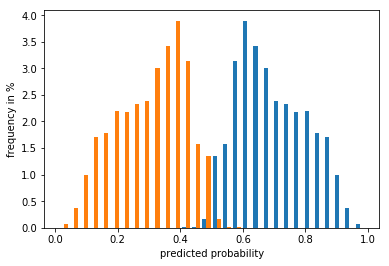

In [102]:
eva.predp_distribution(ypredp)

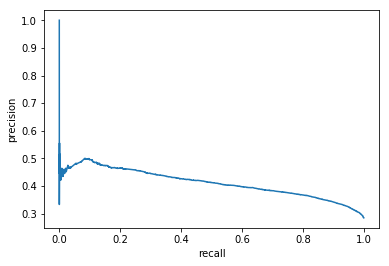

In [103]:
eva.depict_precision_recall_curve(y_test, ypredp)